### Olist cote clients

Nous allons commencer par une segmentation des clients

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter
import seaborn as sns

from collections import OrderedDict
from functools import partial
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,OPTICS, cluster_optics_dbscan

from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score,\
adjusted_rand_score,homogeneity_score, adjusted_mutual_info_score, fowlkes_mallows_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance

import fonctions_olist as fc
#fonctions du cours 'realisez une analyse exploratoire de vos donnees'


In [3]:
data = pd.read_csv("C:/Users/leila/customers.csv", index_col=0)

Nous avons vu precedemment que mean_price_per_order est actuellement fortement correle a invoiced, mean_nb_items est relativement correle a total_item et sellers_prop est inversement correle, dans une mindre mesure a distance_H. Il ne semble pas approprie de garder ces colonnes, cela restera a confirmer.  
Les colonnes concernant la localisation du client peuvent se resumer a la distance_H, on va donc supprimer les autres colonnes sur le sujet, a savoir customer_city et customer_state

In [4]:
dfc = data.drop(['mean_price_per_order','mean_nb_items','customer_city','customer_state'],axis=1)

In [5]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93358 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nb_orders                    93358 non-null  int64  
 1   invoiced                     93358 non-null  float64
 2   mean_diff_payment            93358 non-null  float64
 3   mean_payment_installments    93358 non-null  float64
 4   mean_delivery_nb_days        93358 non-null  float64
 5   mean_review_score            93358 non-null  float64
 6   best_purchase_month          93358 non-null  int64  
 7   baby_toys                    93358 non-null  float64
 8   books_dvd_media_stationery   93358 non-null  float64
 9   fashion_clothes_accessories  93358 non-null  float64
 10  furnitures                   93358 non-null  float64
 11  gifts_flowers                93358 non-null  float64
 12  health_beauty        

**Mise a l'echelle**  
La question qui se pose est quelle mise a l'echelle utiliser ?  
Autant il semble clair que pour les colonnes autres que invoiced, distance_H et mean_freight_per_order, le plus adapte est MinMaxScaler de paart la nature du contenu des colonnes, autant pour les trois restantes il faut regarder les distributions. Soit la distribution est normale et dans ce cas Standard Scaler pourrait etre judicieux (malgre la presence de quelques outliers), soit la distribution n'est pas normale et dans ce cas il faudra choisir entre RobustScaler et MinMax.

In [6]:
# calcul de la moyenne et la mediane si les deux ne sont pas egales, la distribution ne suit pas une loi normale
for col in ['invoiced','distance_H','mean_freight_per_order']:
    print(col, ': moyenne = {}  mediane = {}'.format(dfc[col].mean(), dfc[col].median()))

invoiced : moyenne = 165.1682100087766  mediane = 107.78
distance_H : moyenne = 704.3083618974104  mediane = 337.74
mean_freight_per_order : moyenne = 22.779203002643563  mediane = 17.24


Aucune des distributions n'est normale, afin de garder la positivite des variables et pour ne pas "privilieger" ces trois variables nous allons comme les precedentes, mettre leurs valeurs entre 0 et 1 et donc utiliser MinMax pour toutes les variables.

Afin de se faire une idee, nous allons commencer par travailler sur un echantillon de 10000 observations

In [7]:
minmax = MinMaxScaler()

# select 10000 samples
X_red = dfc.sample(10000, random_state= 23).copy()
# mise a l'echelle
X_red_norm = minmax.fit_transform(X_red)


In [8]:
time_start = time()

pca = PCA(random_state=23)
pca_result = pca.fit(X_red_norm)

print ('PCA done! Time elapsed: {} seconds'.format(time()-time_start))

PCA done! Time elapsed: 0.0673971176147461 seconds


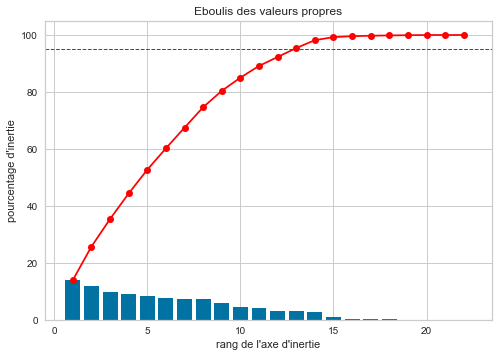

In [9]:
fc.display_scree_plot(pca)

On constate qu'avec 14 composantes on a 98 % de variance expliquee

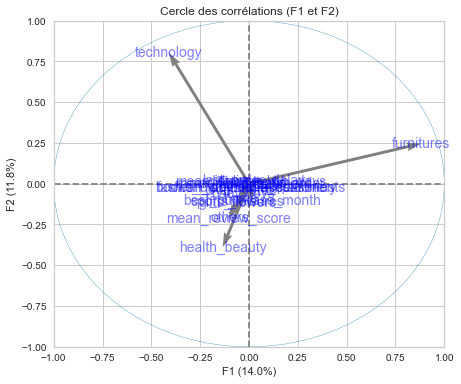

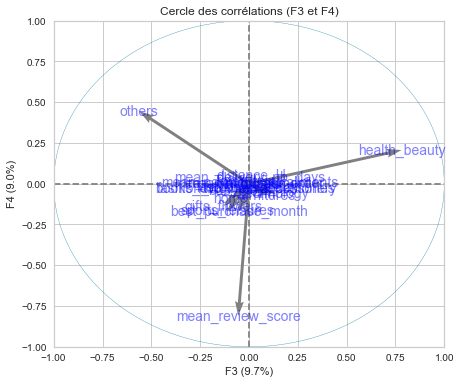

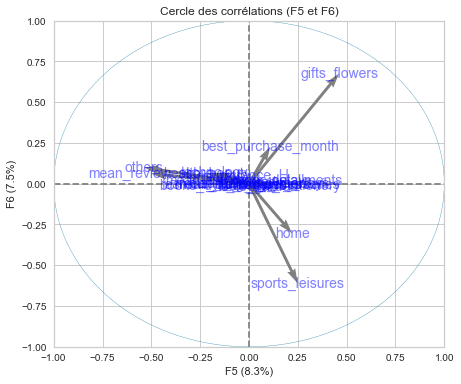

In [10]:
n_comp = 14
pcs = pca.components_
features = X_red.columns
fc.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

La conclusion de ces cercles de correlation est que ce qui concerne les categories est dominant, ce qui ne permettra pas une segmentation utile des clients. On va donc travailler sans les colonnes concernant la categorie de produits

In [11]:
# suppression des colonnes concernant les categories de produits
list_cat = ['health_beauty','sports_leisures','baby_toys','home','furnitures','tools_garden','technology',
          'fashion_clothes_accessories','gifts_flowers','books_dvd_media_stationery','others']
X_out_cat = X_red.drop(list_cat,axis=1)

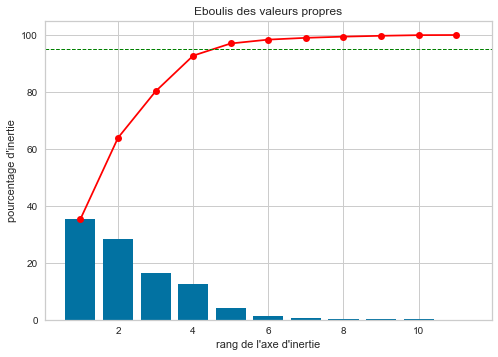

In [12]:
#mise a l'echelle
X_scaled = minmax.fit_transform(X_out_cat)

# pca sur le X reduit
pca_result = pca.fit(X_scaled)
fc.display_scree_plot(pca)

Avec 5 composantes on a 98 % de variance expliquee

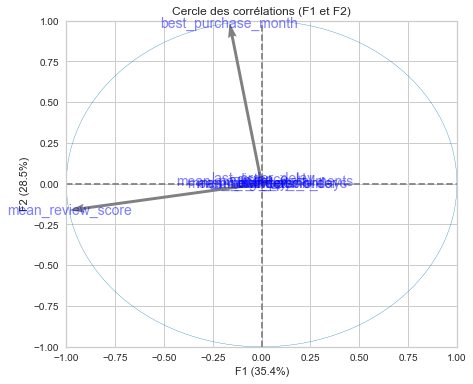

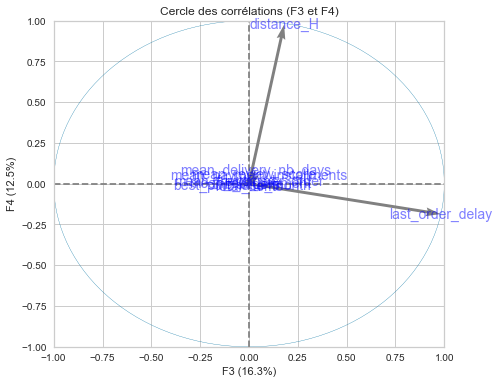

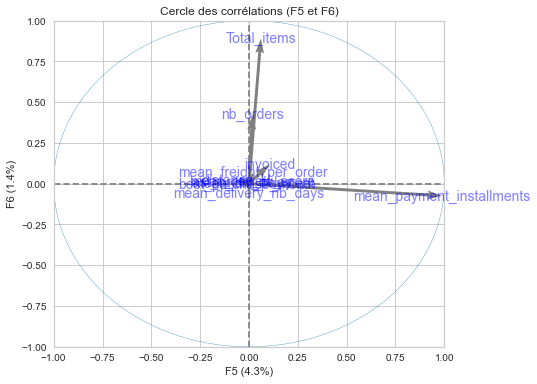

In [13]:
n_comp = 6
pcs = pca.components_
features = X_out_cat.columns
fc.display_circles(pcs, n_comp, pca, [(0,1), (2,3), (4,5)], labels = np.array(features))

Les variables qui contribuent le plus a chaque axe sont clairement identifiables :
- pour $F_1$ : l'avis du client
- pour $F_2$ : mois d'achat
- pour $F_3$ : nombre de jours ecoules depuis la derniere commande
- pour $F_4$ : la localisation du client

In [14]:
pca_result = pca.transform(X_scaled)[:,:5]

# dataframe des resultats de la projection sur les 5 composantes 
df_pca = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4','pca5'])

for k in range(5) :
    df_pca['pca'+str(k+1)] = pca_result[:,k]


<AxesSubplot:title={'center':'Plan factoriel pour les 2 premières composantes de PCA'}, xlabel='Composante 1', ylabel='Composante 2'>

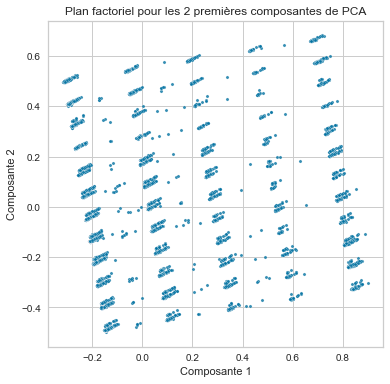

In [15]:
# representation des observations sur le premier plan factoriel
plt.figure(figsize = (6,6))

plt.title('Plan factoriel pour les 2 premières composantes de PCA')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

sns.scatterplot(x = df_pca['pca1'],y = df_pca['pca2'], alpha = 0.8, s = 10)

Representation des donnees suivant des varietes

LLE: 71 sec
LTSA: 71 sec
Modified LLE: 71 sec
Isomap: 40 sec
MDS: 2.9e+02 sec
SE: 42 sec
t-SNE: 75 sec


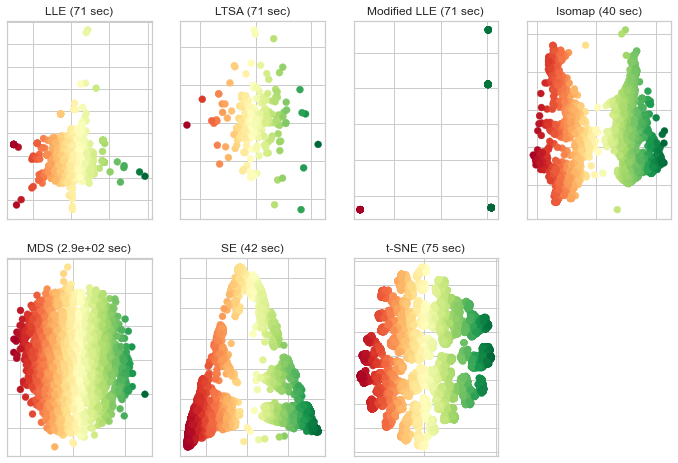

In [16]:
# Create figure
fig = plt.figure(figsize=(15, 8))

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,eigen_solver='dense')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap()
methods['MDS'] = manifold.MDS(max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding()
methods['t-SNE'] = manifold.TSNE( init='pca',random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X_scaled)
    color=Y[:, 0]
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.RdYlGn)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

**KMeans**

Nous allons commencer par la methode du coude pour avoir une idee du nombre de clusters souhaitable, puis nous etudierons le coefficient de silhouette et visualiserons la densite et la separation des clusters pour verifier que les resultats soient coherents

In [17]:
def representer(data,mesure):
    '''Permet de visuliser les differentes mesures utilisees'''
    model=mesure
    model.fit(data)
    model.show()

In [18]:
# mise a l'echelle de pca_result
pca_result_scaled = minmax.fit_transform(pca_result)

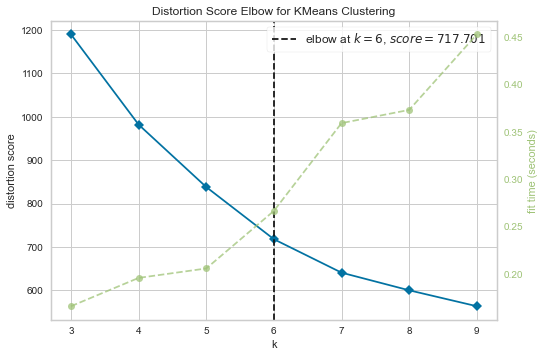

In [19]:
# etude du coude
representer(pca_result_scaled, KElbowVisualizer(KMeans(), k = (3, 10)))                          
 


On constate que le nombre de voisinage recommande par le coude est 6, mais que le coude n'est pas franc

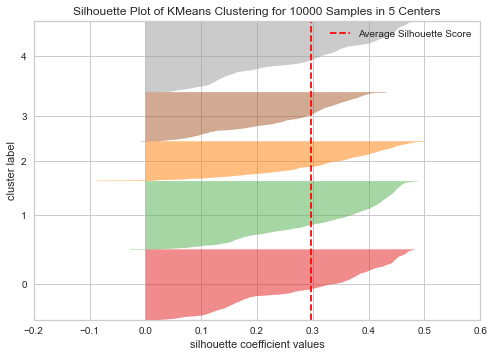

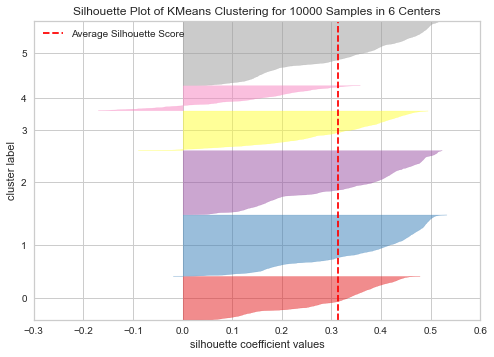

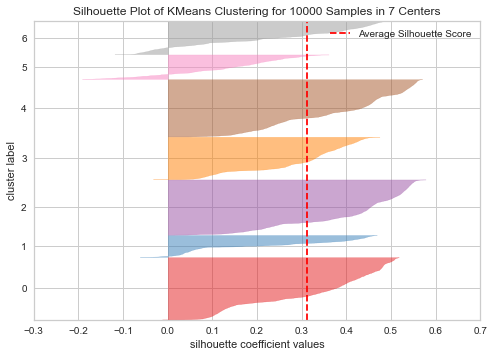

In [20]:
# etude des silhouettes pour les composantes principales
for k in [5,6,7]:
    representer(X_scaled,SilhouetteVisualizer(KMeans(k)))
    

Coefficient de silhouette faible, des observations ne sont pas dans le bon cluster (coefficient de silhouette negatif). Les clusters sont plus equilibres pour 5 clusters

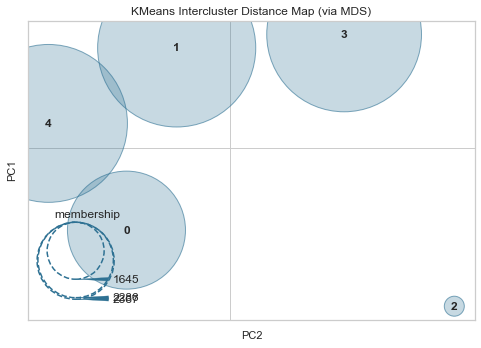

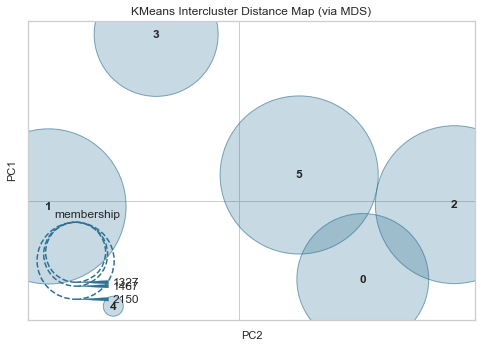

In [21]:
# etude des distance inter-clusters
for k in [5,6] :
    representer(X_scaled,InterclusterDistance(KMeans(k)))
   

On constate un peu moins de chevauchement dans le cas de 5 clusters. La question est peut on deduire des caracteristiques suivant les clusters ?

In [22]:
# clustering by KMeans with 5 clusters
kmeans5 = KMeans(5)
kmeans5.fit(pca_result_scaled)
kmeans5_labels = kmeans5.labels_
df_pca['kmeans_label'] = kmeans5_labels


<AxesSubplot:>

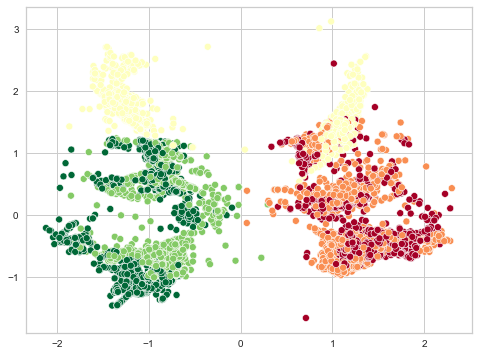

In [23]:
# representation des voisinages par Isomap
Y = manifold.Isomap().fit_transform(X_scaled)
color=df_pca['kmeans_label'].values
plt.figure(figsize=(8,6))
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], c=color, cmap=plt.cm.RdYlGn)


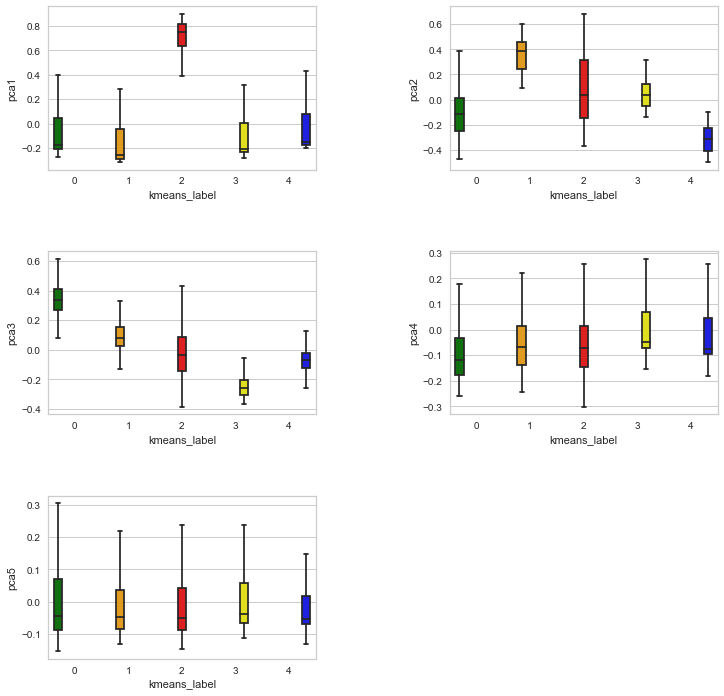

In [24]:
# representation des composantes en fonctions des clusters
fig = plt.figure(figsize = (12, 12))
plt.gcf().subplots_adjust(hspace = 0.5, wspace = 0.5)

for k in range(5) :
    ax = fig.add_subplot(3, 2, 1 + k )
    ax = sns.boxplot(data = df_pca, x = 'kmeans_label', y = 'pca'+str(k+1), hue = 'kmeans_label',
                palette={0:'green', 1:'orange', 2:'red', 3:'yellow', 4:'blue'},showfliers=False)
    plt.gca().legend().set_visible(False)
plt.show()

On va regarder si notre partition est stable si l'on prend maintenant tous les clients

In [25]:
# keeping labels for the sample
X_out_cat['cluster']=kmeans5_labels
X_out_cat.reset_index(inplace=True)

On reitere le processus pour tout le dataset client

In [26]:
list_cat=['health_beauty','sports_leisures','baby_toys','home','furnitures','tools_garden','technology',
          'fashion_clothes_accessories','gifts_flowers','books_dvd_media_stationery','others']
X_tot=dfc.drop(list_cat,axis=1)

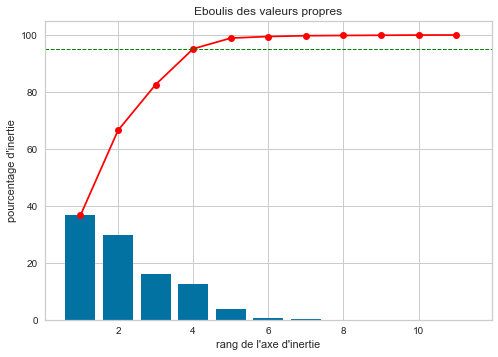

In [27]:
#mise a l'echelle
X_norm=minmax.fit_transform(X_tot)

# pca sur le X tot
pca_tot_result = pca.fit(X_norm)
fc.display_scree_plot(pca)

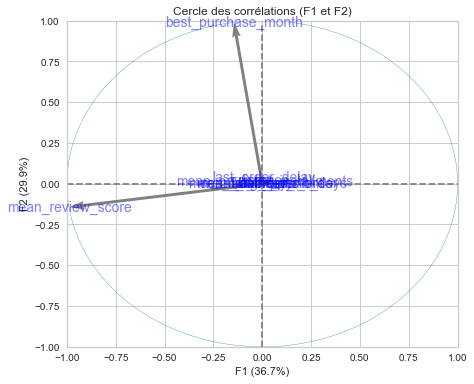

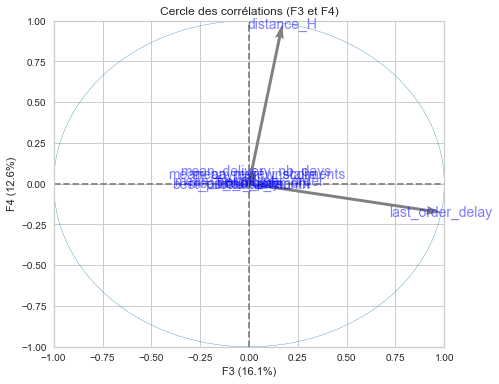

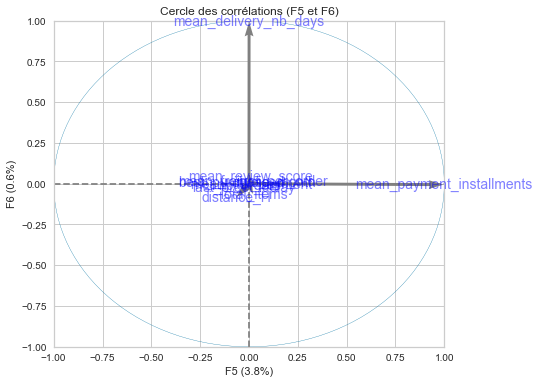

In [28]:
n_comp = 6
pcs = pca.components_
features = X_tot.columns
fc.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

Les variables explicatives sont les memes pour les 5 premieres composantes

In [29]:
pca_tot_result = pca.transform(X_norm)[:,:5]

# dataframe des resultats de la projection sur les 5 composantes 
df_pca_tot = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4','pca5'])

for k in range(5) :
    df_pca_tot['pca'+str(k+1)] = pca_tot_result[:,k]

In [30]:
# mise a l'echelle des projetes
pca_tot_result_scaled = minmax.fit_transform(pca_tot_result)

In [31]:
# clustering 
kmeans5.fit(pca_tot_result_scaled)
kmeans5_tot_labels=kmeans5.labels_
df_pca_tot['kmeans_tot_label']=kmeans5_tot_labels

In [32]:
df_pca_tot['kmeans_tot_label'].value_counts().sort_values()

1    12286
4    15046
2    21559
3    22131
0    22336
Name: kmeans_tot_label, dtype: int64

In [33]:
print('silhouette_score : ', silhouette_score(pca_tot_result_scaled, kmeans5_tot_labels))
print('calinski_harabasz_score : ', calinski_harabasz_score(pca_tot_result_scaled, kmeans5_tot_labels))
print('davies_bouldin_score : ', davies_bouldin_score(pca_tot_result_scaled, kmeans5_tot_labels))

silhouette_score :  0.31665269782955496
calinski_harabasz_score :  38052.74326429462
davies_bouldin_score :  1.138908908529847


In [34]:
# enregistrement des labels
dfc['cluster_client'] = df_pca_tot['kmeans_tot_label'].values


In [35]:
# preparation pour la comparaison des clusters pour le sample de 10000
dfc.reset_index(inplace=True)
compare_labels = pd.merge(X_out_cat[['customer_unique_id','cluster']],
                          dfc[['customer_unique_id','cluster_client']],
                         how = 'left', on = 'customer_unique_id')


In [36]:
labels1 = compare_labels['cluster'].values
labels2 = compare_labels['cluster_client'].values
adjusted_rand_score(labels1,labels2)

0.9981210443609798

On a donc un clustering tres stable sur le nombre de clients. On peut egalement regarder la stabilite a l'initialisation

In [37]:
labels = kmeans5_tot_labels
X_test=pca_tot_result_scaled

In [38]:
def stability_init(model, name, data, labels) :
    
    estimator = model.fit(data)
    results = [name]
    
    # test differents metrics 
    clustering_metrics = [homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score,
                         fowlkes_mallows_score]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]
    
    # print the results
    formatter_result = ("{:9s}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))


print("Scores de stabilité à l'initialisation")
print('Iteration\tHomo\tARI\tAMI\tFMI')
for k in range(10):
    imodel = KMeans(n_clusters=5, n_init=1, init="k-means++")
    stability_init(model = imodel, name = "Test "+str(k), data = X_test, labels = labels)


Scores de stabilité à l'initialisation
Iteration	Homo	ARI	AMI	FMI
Test 0   	1.000	1.000	1.000	1.000
Test 1   	1.000	1.000	1.000	1.000
Test 2   	1.000	1.000	1.000	1.000
Test 3   	1.000	1.000	1.000	1.000
Test 4   	1.000	1.000	1.000	1.000
Test 5   	0.735	0.644	0.768	0.735
Test 6   	1.000	1.000	1.000	1.000
Test 7   	1.000	1.000	1.000	1.000
Test 8   	1.000	1.000	1.000	1.000
Test 9   	1.000	1.000	1.000	1.000


On a une stabilite a l'initialisation relativement bonne.  
Regardons si l'on peut caracteriser les clients suivant leur cluster

In [39]:
mean_per_cluster=dfc.groupby('cluster_client').mean()
mean_per_cluster

,nb_orders,invoiced,mean_diff_payment,mean_payment_installments,mean_delivery_nb_days,mean_review_score,best_purchase_month,baby_toys,books_dvd_media_stationery,fashion_clothes_accessories,...,health_beauty,home,others,sports_leisures,technology,tools_garden,Total_items,last_order_delay,distance_H,mean_freight_per_order
cluster_client,,,,,,,,,,,,,,,,,,,,,
0,1.035727,165.419802,1.035895,2.838717,8.919955,4.625514,6.491001,0.060471,0.038411,0.025543,...,0.145027,0.107784,0.120147,0.073466,0.121953,0.057747,1.158936,60.979719,667.114232,23.621448
1,1.025720,193.525358,1.047134,3.220017,20.227934,1.251500,5.806772,0.066895,0.023995,0.026959,...,0.107414,0.079184,0.109347,0.074090,0.153367,0.048975,1.350562,236.728064,785.037833,27.739090
2,1.034695,160.956694,1.043518,3.041629,12.267504,4.568317,10.197458,0.089178,0.032245,0.039554,...,0.115881,0.066658,0.102621,0.092967,0.126470,0.058265,1.157985,313.320701,715.953690,21.446022
3,1.036329,156.045226,1.039096,2.718086,12.668140,4.547887,2.500610,0.052554,0.039921,0.029229,...,0.116284,0.078242,0.116222,0.091513,0.173879,0.050528,1.150829,179.879038,673.837676,21.443897
4,1.030174,161.092798,1.060581,3.203518,11.741054,4.564555,4.761199,0.075255,0.024885,0.049641,...,0.113768,0.089394,0.101789,0.082460,0.134033,0.043113,1.148744,476.411006,721.735647,21.353187


Les conclusions de ces clusters sont les suivantes :
- cluster 0 : clients satisfaits qui ont recu leurs commandes rapidement apres avoir passer leurs achats generalement en juin et qui sont les plus recents
- cluster 1 : clients tres insatisfaits, en particulier pour un delais de livraison trop long et qui n'ont plus commande depuis 8 mois
- cluster 2 : clients qui commandent vers la fin de l'annee et en moyenne n'ont plus commande depuis 10 mois alors qu'ils etaient satisfaits 
- cluster 3 : clients satisfaits, commandant en debut d'annee qui n'ont plus commande depuis 6 mois
- clusteur 4 : clients satisfaits qui ont recu leur commande dans un delais satisfaisant, qui commandent en moyenne en avril mais qui n'ont pas commande depuis longtemps (16 mois)


In [40]:
# enregistrement du fichier clients avec leur cluster pour transmettre aux vendeurs
dfc.to_csv('customers_labels.csv')

### Stabilite temporelle

L'objectif est de tester dans le temps la stabilite des clusters et voir au bout de combien de temps des clients changent de cluster.  
Sachant que les clients ont commande entre le 4 septembre 2016 et le 17 octobre 2018, on peut partir du dataset des clients ayant commande en 2016 et 2017, puis regarder l'evolution. Pour cela il faut recalculer toutes les features en jeu en fonction de la periode

In [41]:
# data initial 
X_init=fc.data_period(begin=True, period=2)

In [42]:
# ajout de la colonne distance_H
distance=X_tot[X_tot.index.isin(X_init.index)]['distance_H'].values
X_init['distance_H']=distance

In [46]:
def labels_kmeans(data):
    '''Recherche les composantes principales de data puis application de KMeans
    Args : data to cluster
    Returns : labels'''
   
    X_scaled = minmax.fit_transform(data)
    pca_result = pca.fit_transform(X_scaled)[:,:5]
    pca_result_scaled = minmax.fit_transform(pca_result)
    kmeans_p = KMeans(5,random_state = 23)
    kmeans_p.fit(X_scaled)
    return kmeans_p.labels_

In [47]:
# KMeans on initial period
init_labels = labels_kmeans(X_init)

In [48]:
# list ari_score by period
ari_score = []

for p in np.arange(2,11,2):
    # data for period
    data_p = fc.data_period(begin=False, period=p)
    # select initial index and add column distance_H
    data_p = data_p[data_p.index.isin(X_init.index)]
    data_p['distance_H'] = X_init['distance_H'].values
    
    # KMeans
    p_labels = labels_kmeans(data_p)
    
    # ARI score
    ari_p = adjusted_rand_score(init_labels, p_labels)
    ari_score.append([p,ari_p])

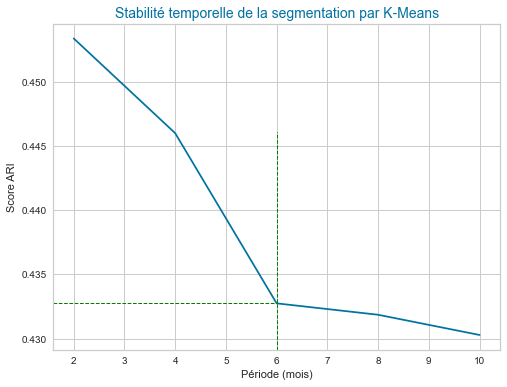

In [49]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(8,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=14,
          color="b")
plt.show()

Les scores de ARI ne sont pas bons puisqu'une des composantes principales est le nomre de jours ecoules depuis la derniere commande donc depend du temps. L'inflexion la plus importante est a 6 mois. La maintenace est donc a faire dans 6 mois et regarder alors de nouveau la stabilite temporelle.

Ci-dessous une tentative de clustering par DBScan via optics sans succes malgre divers essais avec divers parametres

[-1 -1 10 ... -1 -1  7]


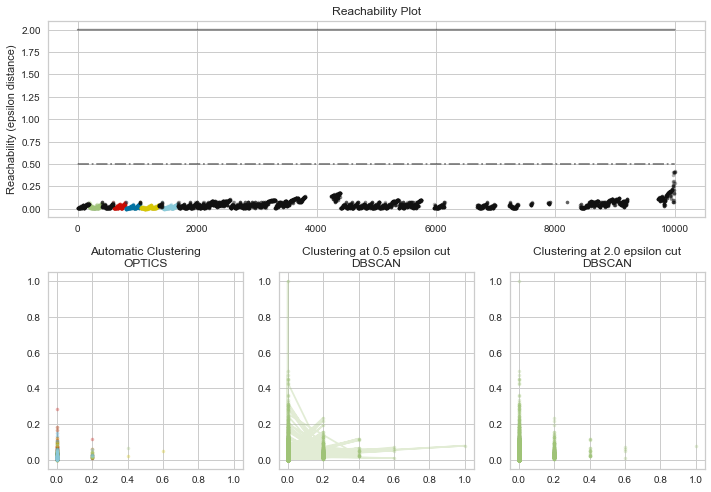

In [51]:
clust = OPTICS(min_samples=7, xi=.05, min_cluster_size=.02)

# Run the fit
clust.fit(pca_result_scaled)
print(clust.labels_)
labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(pca_result_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X_scaled[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_scaled[clust.labels_ == -1, 0], X_scaled[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X_scaled[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X_scaled[labels_050 == -1, 0], X_scaled[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X_scaled[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X_scaled[labels_200 == -1, 0], X_scaled[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()